# 10 – Comparison: Random Forest + Platt vs Bookmakers 

Goals:
- Train our best model: Random Forest with Platt scaling (sigmoid calibration) using engineered features (rolling xG, points, Elo, etc.).
- Generate predicted probabilities for the **test period** (last 20% of matches).
- Merge these probabilities with the `clean_bookmakers_22_23.csv` that already contains average bookmaker odds and implied probabilities.
- Compare model vs bookmakers on:
  - Per-match errors between model and bookmaker probabilities.
  - Summary metrics (RMSE / MAE) for H / D / A.
  - **Side-by-side probability comparison** (scatter plots “model vs book”).
  - **Error distributions** (histograms of errors).
  - **Reliability (calibration) curves** for model vs bookmakers.



In [1]:
# 1: imports and load feature data + bookmaker data

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

df_feat = pd.read_csv("../data/processed/features_matches_long_elo_22_23.csv")
df_book = pd.read_csv("../data/processed/clean_bookmakers_22_23.csv")

print("Features shape:", df_feat.shape)
print("Bookmakers shape:", df_book.shape)


Features shape: (760, 33)
Bookmakers shape: (380, 9)


In [2]:
df_feat.head()

,match_id,season,date,team,opponent,is_home,result,goals_for,goals_against,points,...,strength_points_5,rolling_goal_diff_5,rolling_home_goal_diff_5,rolling_away_goal_diff_5,elo_home_before,elo_away_before,elo_diff_home,elo_team_before,elo_opponent_before,elo_diff_for_team
0,1,2022-2023,2022-08-05,Arsenal,Crystal Palace,0,A,2,0,3,...,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.000000,1500.000000,1500.000000,0.000000
1,16,2022-2023,2022-08-13,Arsenal,Leicester City,1,H,4,2,3,...,NaN,NaN,NaN,NaN,1515.328421,1497.171579,18.156841,1515.328421,1497.171579,18.156841
2,23,2022-2023,2022-08-20,Arsenal,Bournemouth,0,A,3,0,3,...,NaN,NaN,NaN,NaN,1500.192375,1524.387995,-24.195620,1524.387995,1500.192375,24.195620
3,35,2022-2023,2022-08-27,Arsenal,Fulham,1,H,2,1,3,...,NaN,NaN,NaN,NaN,1538.878630,1509.853905,29.024725,1538.878630,1509.853905,29.024725
4,49,2022-2023,2022-08-31,Arsenal,Aston Villa,1,H,2,1,3,...,NaN,NaN,NaN,NaN,1547.580022,1473.449924,74.130098,1547.580022,1473.449924,74.130098


In [3]:
df_book.head()

,date,home_team,away_team,home_odds,draw_odds,away_odds,prob_book_home,prob_book_draw,prob_book_away
0,2022-08-05,Crystal Palace,Arsenal,4.366667,3.583333,1.856667,0.218795,0.266625,0.514581
1,2022-08-06,Fulham,Liverpool,11.400000,5.906667,1.266667,0.083822,0.161779,0.754399
2,2022-08-06,Bournemouth,Aston Villa,3.810000,3.460000,2.030000,0.251382,0.276811,0.471806
3,2022-08-06,Leeds United,Wolverhampton Wanderers,2.296667,3.343333,3.233333,0.417145,0.286553,0.296302
4,2022-08-06,Newcastle United,Nottingham Forest,1.680000,3.746667,5.443333,0.569141,0.255202,0.175657


In [4]:
# 2: prepare dataset (select features, target, handle NaNs, sort by date)

# Feature columns used in the calibrated experiments
feature_cols = [
    "is_home",
    "rolling_xg_for_5",
    "rolling_xg_against_5",
    "rolling_xg_diff_5",
    "rolling_points_5",
    "strength_points_5",
    "elo_home_before",
    "elo_away_before",
    "elo_diff_home",
]

target_col = "result"  # values: 'H', 'D', 'A'

print("\nNaN BEFORE drop:")
print(df_feat[feature_cols + [target_col]].isna().sum())

df_feat = df_feat.dropna(subset=feature_cols + [target_col]).reset_index(drop=True)

print("\nNaN AFTER drop:")
print(df_feat[feature_cols + [target_col]].isna().sum())
print("Cleaned features shape:", df_feat.shape)

# Sort by date to respect time order
df_feat = df_feat.sort_values("date").reset_index(drop=True)


NaN BEFORE drop:
is_home                   0
rolling_xg_for_5        100
rolling_xg_against_5    100
rolling_xg_diff_5       100
rolling_points_5        100
strength_points_5       200
elo_home_before           0
elo_away_before           0
elo_diff_home             0
result                    0
dtype: int64

NaN AFTER drop:
is_home                 0
rolling_xg_for_5        0
rolling_xg_against_5    0
rolling_xg_diff_5       0
rolling_points_5        0
strength_points_5       0
elo_home_before         0
elo_away_before         0
elo_diff_home           0
result                  0
dtype: int64
Cleaned features shape: (560, 33)


In [5]:
# 3: time-based train/test split (80% train, 20% test)

X = df_feat[feature_cols].copy()
y = df_feat[target_col].copy()

train_size = int(0.8 * len(df_feat))

X_train = X.iloc[:train_size]
X_test  = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes :", X_test.shape, y_test.shape)

Train shapes: (448, 9) (448,)
Test shapes : (112, 9) (112,)


In [6]:
# 4: encode target (H/D/A) and scale features

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Classes (encoding order):", le.classes_)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train scaled shape:", X_train_scaled.shape)
print("Test scaled shape :", X_test_scaled.shape)

Classes (encoding order): ['A' 'D' 'H']
Train scaled shape: (448, 9)
Test scaled shape : (112, 9)


In [7]:
# 5: train Random Forest with Platt scaling (sigmoid calibration)

rf_base = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

rf_platt = CalibratedClassifierCV(
    estimator=rf_base,
    method="sigmoid",  # Platt scaling
    cv=3,
)

rf_platt.fit(X_train_scaled, y_train_enc)

print("Random Forest + Platt model trained!")


Random Forest + Platt model trained!


In [8]:
# 6: get model probabilities on the test set and align with matches

y_proba_test = rf_platt.predict_proba(X_test_scaled)

print("Predicted probabilities shape (test):", y_proba_test.shape)

# Map columns of y_proba_test to classes 'A', 'D', 'H'
class_to_idx = {cls: idx for idx, cls in enumerate(le.classes_)}
idx_A = class_to_idx["A"]
idx_D = class_to_idx["D"]
idx_H = class_to_idx["H"]

# Slice the original dataframe for the test period
df_test = df_feat.iloc[train_size:].copy().reset_index(drop=True)

# Add model probabilities for A/D/H
df_test["prob_model_away"] = y_proba_test[:, idx_A]
df_test["prob_model_draw"] = y_proba_test[:, idx_D]
df_test["prob_model_home"] = y_proba_test[:, idx_H]

# Keep only home rows to have one row per match
# (Assumes df_feat has 'is_home' and uses one row per team; home row = match)
df_test_home = df_test[df_test["is_home"] == 1].copy()

# If your feature file has 'team' and 'opponent' columns:
# 'team' is home_team when is_home == 1.
df_test_home.rename(
    columns={
        "team": "home_team_model",
        "opponent": "away_team_model",
    },
    inplace=True,
)

print("Test matches (home rows only):", len(df_test_home))
df_test_home[[
    "date",
    "home_team_model",
    "away_team_model",
    "result",
    "prob_model_home",
    "prob_model_draw",
    "prob_model_away",
]].head()

Predicted probabilities shape (test): (112, 3)
Test matches (home rows only): 56


,date,home_team_model,away_team_model,result,prob_model_home,prob_model_draw,prob_model_away
3,2023-04-29,Brighton & Hove Albion,Wolverhampton Wanderers,H,0.597272,0.172379,0.230348
4,2023-04-29,Crystal Palace,West Ham United,H,0.590787,0.182790,0.226424
5,2023-04-29,Brentford,Nottingham Forest,H,0.572677,0.201386,0.225937
6,2023-04-30,Fulham,Manchester City,A,0.210135,0.290069,0.499797
7,2023-04-30,Manchester United,Aston Villa,H,0.578618,0.178938,0.242444


In [9]:
# 7: merge bookmaker probabilities with model probabilities

print(df_book.columns)

df_merge = df_book.merge(
    df_test_home[
        [
            "date",
            "home_team_model",
            "away_team_model",
            "result",
            "prob_model_home",
            "prob_model_draw",
            "prob_model_away",
        ]
    ],
    left_on=["date", "home_team", "away_team"],
    right_on=["date", "home_team_model", "away_team_model"],
    how="left",
    validate="1:1",
)

# Drop helper columns
df_merge.drop(columns=["home_team_model", "away_team_model"], inplace=True)

print("Merged shape (full season):", df_merge.shape)

# Keep only matches where the model produced probabilities (test period)
df_merge_test = df_merge[df_merge["prob_model_home"].notna()].copy()
print("Merged shape (test matches only):", df_merge_test.shape)

df_merge_test[[
    "date",
    "home_team",
    "away_team",
    "result",
    "prob_model_home",
    "prob_book_home",
    "prob_model_draw",
    "prob_book_draw",
    "prob_model_away",
    "prob_book_away",
]].head()

Index(['date', 'home_team', 'away_team', 'home_odds', 'draw_odds', 'away_odds',
       'prob_book_home', 'prob_book_draw', 'prob_book_away'],
      dtype='object')
Merged shape (full season): (380, 13)
Merged shape (test matches only): (56, 13)


,date,home_team,away_team,result,prob_model_home,prob_book_home,prob_model_draw,prob_book_draw,prob_model_away,prob_book_away
324,2023-04-29,Crystal Palace,West Ham United,H,0.590787,0.355380,0.182790,0.298682,0.226424,0.345938
325,2023-04-29,Brentford,Nottingham Forest,H,0.572677,0.575650,0.201386,0.251028,0.225937,0.173322
326,2023-04-29,Brighton & Hove Albion,Wolverhampton Wanderers,H,0.597272,0.638739,0.172379,0.219950,0.230348,0.141311
327,2023-04-30,Bournemouth,Leeds United,H,0.377675,0.370620,0.253639,0.274337,0.368686,0.355044
328,2023-04-30,Fulham,Manchester City,A,0.210135,0.079457,0.290069,0.156350,0.499797,0.764193


In [10]:
# 8: pointwise errors and summary RMSE / MAE

# Pointwise errors (model - bookmakers) for each outcome
df_merge_test["err_home"] = df_merge_test["prob_model_home"] - df_merge_test["prob_book_home"]
df_merge_test["err_draw"] = df_merge_test["prob_model_draw"] - df_merge_test["prob_book_draw"]
df_merge_test["err_away"] = df_merge_test["prob_model_away"] - df_merge_test["prob_book_away"]

def rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

def mae(a, b):
    return float(mean_absolute_error(a, b))

summary_errors = []

for outcome_label, col_model, col_book in [
    ("H", "prob_model_home", "prob_book_home"),
    ("D", "prob_model_draw", "prob_book_draw"),
    ("A", "prob_model_away", "prob_book_away"),
]:
    rmse_val = rmse(df_merge_test[col_model], df_merge_test[col_book])
    mae_val  = mae(df_merge_test[col_model], df_merge_test[col_book])

    summary_errors.append(
        {
            "outcome": outcome_label,
            "RMSE_model_vs_book": rmse_val,
            "MAE_model_vs_book": mae_val,
        }
    )

df_summary_errors = pd.DataFrame(summary_errors)
df_summary_errors

,outcome,RMSE_model_vs_book,MAE_model_vs_book
0,H,0.135091,0.110913
1,D,0.062017,0.048387
2,A,0.119147,0.097778


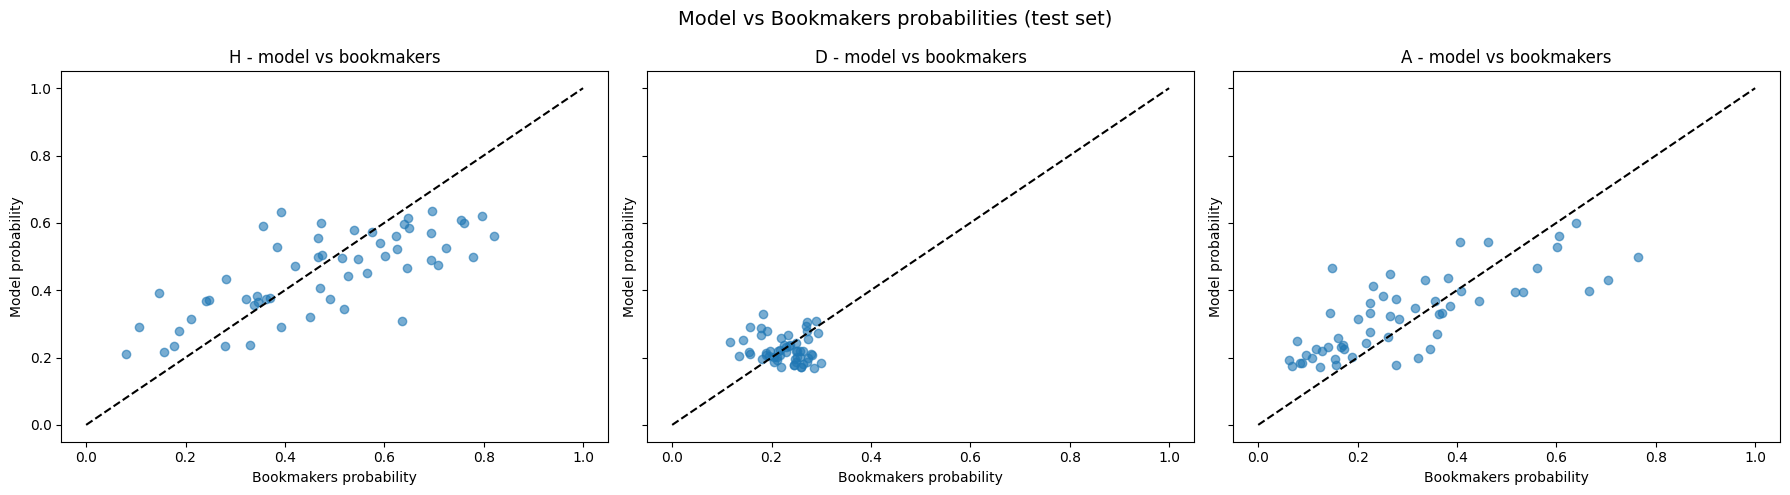

In [11]:
# 9: scatter plots (3-in-1) - model probabilities vs bookmaker probabilities

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

settings = [
    ("H", "prob_book_home", "prob_model_home", axes[0]),
    ("D", "prob_book_draw", "prob_model_draw", axes[1]),
    ("A", "prob_book_away", "prob_model_away", axes[2]),
]

for label, col_book, col_model, ax in settings:
    ax.scatter(
        df_merge_test[col_book],
        df_merge_test[col_model],
        alpha=0.6,
    )
    # 45-degree line
    ax.plot([0, 1], [0, 1], "--", color="black")
    ax.set_title(f"{label} - model vs bookmakers")
    ax.set_xlabel("Bookmakers probability")
    ax.set_ylabel("Model probability")

fig.suptitle("Model vs Bookmakers probabilities (test set)", fontsize=14)
plt.tight_layout()
plt.show()

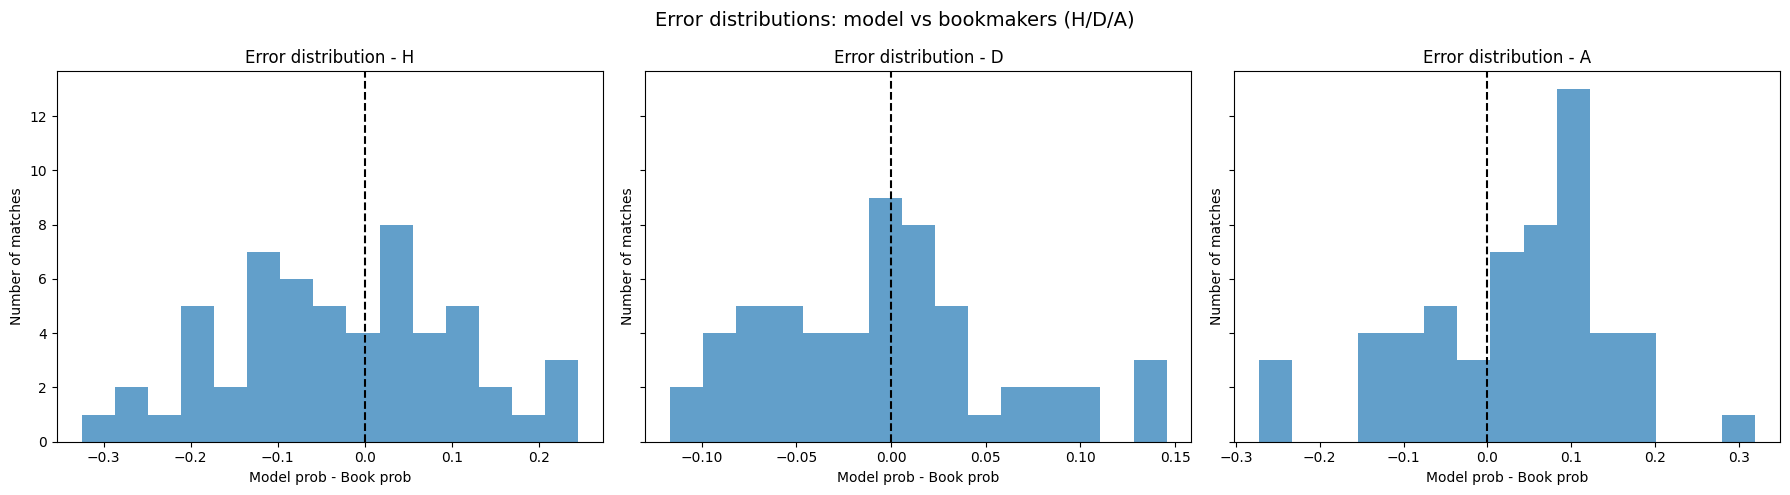

In [12]:
# 10: error distributions (3-in-1 histograms)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

error_settings = [
    ("H", "err_home", axes[0]),
    ("D", "err_draw", axes[1]),
    ("A", "err_away", axes[2]),
]

for label, col_err, ax in error_settings:
    ax.hist(df_merge_test[col_err], bins=15, alpha=0.7)
    ax.axvline(0.0, color="black", linestyle="--")
    ax.set_title(f"Error distribution - {label}")
    ax.set_xlabel("Model prob - Book prob")
    ax.set_ylabel("Number of matches")

fig.suptitle("Error distributions: model vs bookmakers (H/D/A)", fontsize=14)
plt.tight_layout()
plt.show()

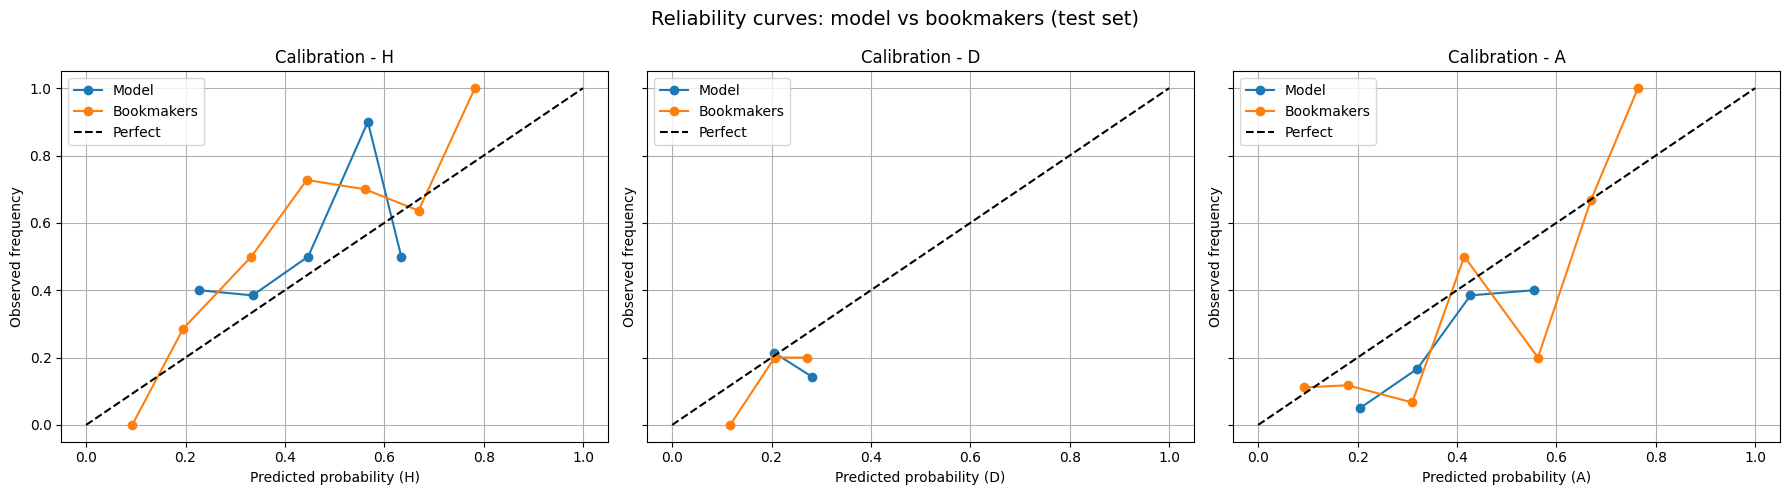

In [13]:
# 11: calibration (reliability) curves – 3 subplots: H / D / A

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

calib_settings = [
    ("H", "prob_model_home", "prob_book_home", axes[0]),
    ("D", "prob_model_draw", "prob_book_draw", axes[1]),
    ("A", "prob_model_away", "prob_book_away", axes[2]),
]

for outcome_label, col_model_prob, col_book_prob, ax in calib_settings:
    # Binary true labels: 1 if this outcome happened, 0 otherwise
    y_true = (df_merge_test["result"] == outcome_label).astype(int).values

    p_model = df_merge_test[col_model_prob].values
    p_book  = df_merge_test[col_book_prob].values

    frac_model, mean_pred_model = calibration_curve(y_true, p_model, n_bins=8, strategy="uniform")
    frac_book, mean_pred_book = calibration_curve(y_true, p_book, n_bins=8, strategy="uniform")

    ax.plot(mean_pred_model, frac_model, "o-", label="Model")
    ax.plot(mean_pred_book, frac_book, "o-", label="Bookmakers")
    ax.plot([0, 1], [0, 1], "--", color="black", label="Perfect")

    ax.set_title(f"Calibration - {outcome_label}")
    ax.set_xlabel(f"Predicted probability ({outcome_label})")
    ax.set_ylabel("Observed frequency")
    ax.grid(True)
    ax.legend()

fig.suptitle("Reliability curves: model vs bookmakers (test set)", fontsize=14)
plt.tight_layout()
plt.show()

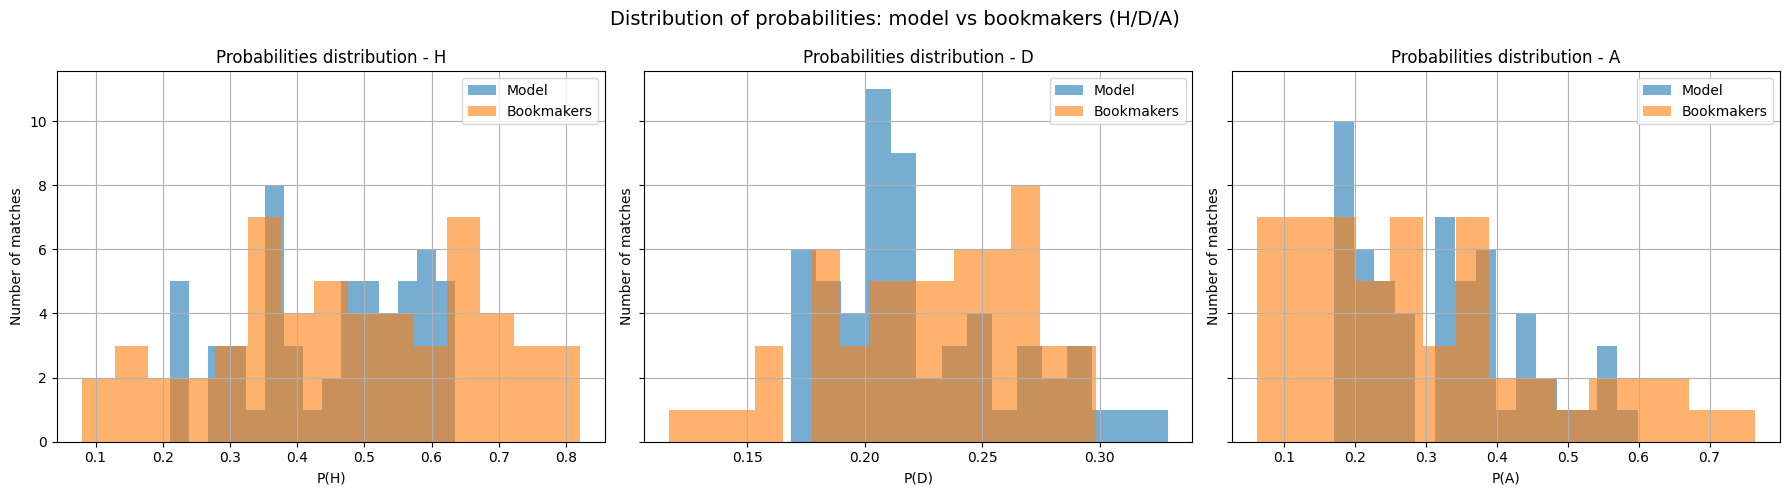

In [14]:
# 12: distributions of probabilities (3-in-1) – model vs bookmakers

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

dist_settings = [
    ("H", "prob_model_home", "prob_book_home", axes[0]),
    ("D", "prob_model_draw", "prob_book_draw", axes[1]),
    ("A", "prob_model_away", "prob_book_away", axes[2]),
]

for label, col_model, col_book, ax in dist_settings:
    ax.hist(
        df_merge_test[col_model],
        bins=15,
        alpha=0.6,
        label="Model",
    )
    ax.hist(
        df_merge_test[col_book],
        bins=15,
        alpha=0.6,
        label="Bookmakers",
    )

    ax.set_title(f"Probabilities distribution - {label}")
    ax.set_xlabel(f"P({label})")
    ax.set_ylabel("Number of matches")
    ax.grid(True)
    ax.legend()

fig.suptitle("Distribution of probabilities: model vs bookmakers (H/D/A)", fontsize=14)
plt.tight_layout()
plt.show()